Capstone Project - Battle of Neighborhood
# **Analysing and Predicting optimal locations for popular restaurants in Chennai city**

## Table of contents
* [Introduction](#introduction)
* [Problem Definition](#problem-def)
* [Data Acquisition](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results](#results)
* [Conclusion and Discussion](#conclusion)

## Introduction <a name="introduction"></a>

Chennai, also known as Madras, is the capital of the Indian state of Tamil Nadu. Located on the Coromandel Coast of the Bay of Bengal, it is one of the largest cultural, economic and educational centres of south India. According to the 2011 Indian census, it is the sixth-most populous city and fourth-most populous urban agglomeration in India. The Chennai Metropolitan Area is the 36th-largest urban area by population in the world. The traditional and de facto gateway of South India, Chennai is among the most-visited Indian cities by foreign tourists. It was ranked the 36th-most visited city in the world for the year 2019. The Quality of Living Survey rated Chennai as the safest city in India. Chennai has the fifth-largest urban economy of India.

The diversity of the cuisine available is reflective of the social and economic diversity of Chennai. Indian, Chinese, Asian, Italian, Middle Eastern, Thai are some of the most popular in the city. We will analyze each of these restaurant to predict a suitable location for the respective restaurant.

## Problem Definition <a name="problem-def"></a>

In this capstone project, we will try to visualize all major parts and areas of the Chennai City and try to predict an optimal location for an each of the restaurant. Since there are lots of restaurants in Chennai, we try to select those locations that are not already crowded with restaurants within the region.

In particular, the concluded project report will target stakeholders who wants to set up one of the popular restaurant in Chennai, Tamil Nadu, India. We will use various data science and analysis techniques to reach our goal of selecting optimal locations. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

## Data Acquisition <a name="data"></a>

The data and their respective data sources for our projects are discussed below,

1. Chennai city's major areas and neighbourhood

  **Data Source:** [Wikipedia](https://en.wikipedia.org/wiki/Areas_of_Chennai)

  **Data description:** We will initialize crawler to scrape and extract data and information about the areas and locality from the wikipedia web page.

2. Geographical coordinate of the areas

  **Data Source:** Python's [geocoder library](https://geocoder.readthedocs.io/index.html)

  **Data description:** Geocoder is a simple and consistent geocoding library written in Python. Dealing with multiple different geocoding provider such as Google, Bing, OSM and many more. Specifically, we will be using ArcGIS, as it is reliable and free.

3. To get nearby venues in each locality of Chennai city,

  **Data Source:** [Foursquare API](https://foursquare.com/)

  **Data description:** This API allows us to get information about all the venues in the neighbourhood of Chennai City. Foursquare Credentials is used to fetch the data.

### Importing necessary modules

In [1]:
from collections import Counter

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import pickle

### Web Scraping - Wikipedia

Wikipedia page has the neighborhood details. Using web scraping technique, we fetch the neighborhood details from the wiki page.

In [2]:
import requests
from bs4 import BeautifulSoup

In [3]:
url = "https://en.wikipedia.org/wiki/Areas_of_Chennai"

In [4]:
r = requests.get(url)
soup = BeautifulSoup(r.text, "html.parser")
areas = soup.find('table', {'class': 'wikitable'}).find_all('a')

### Geographical coordinates - Geocoder library

Geocoder is a simple and consistent geocoding library written in Python. Dealing with multiple different geocoding provider such as Google, Bing, OSM and many more. Specifically, we will be using ArcGIS, as it is reliable and free.

In [5]:
!pip install geocoder -q
import geocoder

     |████████████████████████████████| 102kB 3.8MB/s 


In [6]:
chennai_df = pd.DataFrame()
for i, neighbor in enumerate(areas):
  print('\rProcessing:', i+1, end="")
  record = [neighbor.text.strip()]
  record.extend(geocoder.arcgis(f'{record[0]}, Chennai, Tamil Nadu, India').latlng)
  chennai_df=chennai_df.append([record], ignore_index=True)

chennai_df.columns=['Neighborhood', 'Latitude', 'Longitude']
chennai_df.drop_duplicates('Neighborhood', inplace=True)
chennai_df.head()

Processing: 163

,Neighborhood,Latitude,Longitude
0,Adambakkam,12.99192,80.20603
1,Adyar,13.00304,80.25187
2,Alandur,13.00013,80.20049
3,Alapakkam,13.04613,80.16501
4,Alwarpet,13.03471,80.25416


In [7]:
chennai_df.isna().sum()

Neighborhood    0
Latitude        0
Longitude       0
dtype: int64

Save `chennai_df` dataframe to pickle file

In [8]:
with open('chennai_df.pkl', 'wb') as f:
  pickle.dump(chennai_df, f)

Load `chennai_df` dataframe from pickle file

In [9]:
with open("chennai_df.pkl", "rb") as f:
  chennai_df = pickle.load(f)

chennai_df.head()

,Neighborhood,Latitude,Longitude
0,Adambakkam,12.99192,80.20603
1,Adyar,13.00304,80.25187
2,Alandur,13.00013,80.20049
3,Alapakkam,13.04613,80.16501
4,Alwarpet,13.03471,80.25416


#### Vizualizing neigborhoods - Folium

Folium is a powerful data visualization library in Python that was built primarily to visualize geospatial data. With Folium, one can create a map of any location in the world if its latitude and longitude values are known.

In [10]:
from geopy.geocoders import Nominatim

import folium
from folium.plugins import HeatMap

In [11]:
address = 'Chennai, Tamil Nadu'
geolocator = Nominatim(user_agent="chennai_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Chennai is {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Chennai is 13.0836939, 80.270186.


In [12]:
# create map of Chennai using latitude and longitude values
map_chennai = folium.Map(location=[latitude, longitude], zoom_start=11)
folium.Marker([latitude, longitude], popup='Chennai').add_to(map_chennai)

# add markers to map
for lat, lng, neighborhood in zip(chennai_df['Latitude'], chennai_df['Longitude'], chennai_df['Neighborhood']):
    label = folium.Popup(neighborhood, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chennai)
    #folium.Circle([lat, lng], radius=1500, color='red', fill=True, fill_opacity=1).add_to(map_chennai)
    
map_chennai

### Fetching neighborhood venues - Foursquare API

Now that we have our location candidates, let's use Foursquare API to get info of all the venues in each of the neighborhood.

In [17]:
# Foursquare credential
%run foursquare_api.py
LIMIT = 100 # A default Foursquare API limit value

Define a function `getNearbyVenues`, to extract useful information using Foursquare API service.

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
chennai_venues = getNearbyVenues(names=chennai_df['Neighborhood'],
                                latitudes=chennai_df['Latitude'],
                                longitudes=chennai_df['Longitude'],
                                radius=1500)
chennai_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adambakkam,12.99192,80.20603,Luxe Cinemas,12.991041,80.216962,Multiplex
1,Adambakkam,12.99192,80.20603,Phoenix Market City,12.991710,80.217297,Shopping Mall
2,Adambakkam,12.99192,80.20603,IMAX®,12.990639,80.216310,Multiplex
3,Adambakkam,12.99192,80.20603,Pizza Republic,12.990987,80.198613,Pizza Place
4,Adambakkam,12.99192,80.20603,Mainland China,12.991028,80.217084,Chinese Restaurant


In [19]:
chennai_venues.shape

(3890, 7)

In [20]:
chennai_venues.drop_duplicates(["Venue", "Venue Latitude", "Venue Longitude"], inplace=True, ignore_index=True)
chennai_venues.shape

(1859, 7)

Save `chennai_venues` dataframe to pickle file

In [21]:
with open('chennai_venues.pkl', 'wb') as f:
  pickle.dump(chennai_venues, f)

Load `chennai_venues` dataframe from pickle file

In [26]:
with open('chennai_venues.pkl', 'rb') as f:
  chennai_venues = pickle.load(f)

chennai_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adambakkam,12.99192,80.20603,Luxe Cinemas,12.991041,80.216962,Multiplex
1,Adambakkam,12.99192,80.20603,Phoenix Market City,12.991710,80.217297,Shopping Mall
2,Adambakkam,12.99192,80.20603,Mainland China,12.991028,80.217084,Chinese Restaurant
3,Adambakkam,12.99192,80.20603,IMAX®,12.990639,80.216310,Multiplex
4,Adambakkam,12.99192,80.20603,Sukkkubai Beef Biryani Shop,12.998769,80.201381,Indian Restaurant


In [27]:
chennai_venues.groupby('Neighborhood').count()[['Venue']].head()

,Venue
Neighborhood,
Adambakkam,60
Adyar,70
Alandur,17
Alapakkam,12
Alwarpet,100


In [28]:
print('There are {} uniques categories.'.format(len(chennai_venues['Venue Category'].unique())))

There are 211 uniques categories.


#### Vizualizing restaurants - Folium

Filter out only the restaurant from all the venues

In [29]:
restaurant = ['restaurant', 'diner', 'taverna', 'steakhouse']

chennai_restaurant = chennai_venues[[np.any([r in x.lower() for r in restaurant]) for x in chennai_venues['Venue Category']]].reset_index(drop=True)
chennai_restaurant.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adambakkam,12.99192,80.20603,Mainland China,12.991028,80.217084,Chinese Restaurant
1,Adambakkam,12.99192,80.20603,Sukkkubai Beef Biryani Shop,12.998769,80.201381,Indian Restaurant
2,Adambakkam,12.99192,80.20603,Rajdhani,12.991081,80.217003,Rajasthani Restaurant
3,Adambakkam,12.99192,80.20603,Haven Sampoorna,12.990324,80.219003,Vegetarian / Vegan Restaurant
4,Adambakkam,12.99192,80.20603,Kobe Sizzlers,12.992141,80.217139,Restaurant


Save `chennai_restaurant` dataframe to pickle file

In [ ]:
with open('chennai_restaurant.pkl', 'wb') as f:
  pickle.dump(chennai_restaurant, f)

Load `chennai_restaurant` dataframe from pickle file

In [30]:
with open('chennai_restaurant.pkl', 'rb') as f:
  chennai_restaurant = pickle.load(f)

chennai_restaurant.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adambakkam,12.99192,80.20603,Mainland China,12.991028,80.217084,Chinese Restaurant
1,Adambakkam,12.99192,80.20603,Sukkkubai Beef Biryani Shop,12.998769,80.201381,Indian Restaurant
2,Adambakkam,12.99192,80.20603,Rajdhani,12.991081,80.217003,Rajasthani Restaurant
3,Adambakkam,12.99192,80.20603,Haven Sampoorna,12.990324,80.219003,Vegetarian / Vegan Restaurant
4,Adambakkam,12.99192,80.20603,Kobe Sizzlers,12.992141,80.217139,Restaurant


Percentage of each of the restaurant type

In [31]:
chennai_restaurant.groupby("Venue Category").count()["Venue"].sort_values(ascending=False) / len(chennai_restaurant) * 100

Venue Category
Indian Restaurant                  41.678322
Fast Food Restaurant               10.000000
Vegetarian / Vegan Restaurant       7.902098
Chinese Restaurant                  6.503497
Restaurant                          5.804196
Italian Restaurant                  4.405594
South Indian Restaurant             4.125874
Asian Restaurant                    3.986014
Middle Eastern Restaurant           2.447552
Thai Restaurant                     1.188811
Diner                               1.048951
American Restaurant                 0.979021
Japanese Restaurant                 0.839161
Seafood Restaurant                  0.839161
Mediterranean Restaurant            0.699301
Mexican Restaurant                  0.629371
Modern European Restaurant          0.629371
Kerala Restaurant                   0.559441
Kebab Restaurant                    0.559441
Multicuisine Indian Restaurant      0.559441
Comfort Food Restaurant             0.489510
Hyderabadi Restaurant               0.41

Some of most popular restaurant type are,

1. Indian Restaurant
2. Fast Food Restaurant
3. Vegetarian Restaurant
4. Chinese Restaurant
5. General Restaurant
6. Asian Restaurant
7. Italian Restaurant

In [32]:
target_restaurant = ["Indian Restaurant", "Fast Food Restaurant", "Vegetarian / Vegan Restaurant", "Chinese Restaurant", "Asian Restaurant", "Italian Restaurant"]

Vizualizing Indian Restaurant vs other Restaurant

In [33]:
# create map of Chennai using latitude and longitude values
map_chennai = folium.Map(location=[latitude, longitude], zoom_start=11)
folium.Marker([latitude, longitude], popup="Chennai city").add_to(map_chennai)

# add markers to map
for lat, lng, category in zip(chennai_restaurant['Neighborhood Latitude'], chennai_restaurant['Neighborhood Longitude'], chennai_restaurant['Venue Category']):
    label = folium.Popup(category, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue' if category == "Indian Restaurant" else "red",
        fill=True,
        fill_opacity=1,
        parse_html=False).add_to(map_chennai)  
    
map_chennai

Output hidden; open in https://colab.research.google.com to view.

Indian restaurant only constitute ~42% of all the restaurant in the city of Chennai.

## Methodology <a name="methodology"></a>

In this project, we use clustering algorithm like `KMeans` to cluster the neighborhood based on the venue frequency and analyze each cluster to select the optimal location for each of the restaurant type.

Previously, we have already collected the required data, from various data sources like Wikipedia, Geocoder, Foursquare API service. We have also filtered all the restaurant type from the venues.

Next, we will analyze each of the popular restaurant type and explore the 'restaurant density' across the areas of Chennai city. We will be using Heatmaps to identify few promising areas with low number of restaurants in general and no popular restaurant type within the vicinity.

We will also cluster the neighborhood based on the general venue frequency and compare the sets in each cluster to conclude the most promising and optimal location for each of the restaurant type.

In [34]:
map_chennai = folium.Map([lat, lng], zoom_start=11)
folium.Marker([latitude, longitude], popup="Chennai city").add_to(map_chennai)

HeatMap(chennai_restaurant[["Venue Latitude", "Venue Longitude"]].to_numpy()).add_to(map_chennai)

map_chennai

## Analysis <a name="analysis"></a>

First, we need to cluster the neighborhoods and then analyze each of the clusters. The results will allow us to identify similar neighbourhoods with the concentration of Restaurants type. Based on the occurrence of these restaurants type in different neighbourhoods, we will try to answer the question as to which neighbourhoods are most suitable to open the respective restaurants. In particular, we will target those neighborhood that has less than 20% of the restaurant and no target restaurant.

We will use One-Hot encoding which allows the representation of categorical data to be more expressive. Many machine learning algorithms cannot work with categorical data directly. The categories must be converted into numbers. In our case, venue category are expressed as the mean of the frequency of occurrence of each category.

In [35]:
chennai_onehot = pd.get_dummies(chennai_venues[['Venue Category']], prefix="", prefix_sep="")
chennai_onehot['Neighborhood'] = chennai_venues['Neighborhood']
fixed_columns = ['Neighborhood'] + list(chennai_onehot.columns.drop('Neighborhood'))
chennai_onehot = chennai_onehot[fixed_columns]

chennai_onehot.head()

,Neighborhood,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Terminal,American Restaurant,Andhra Restaurant,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Badminton Court,Bakery,Bank,Bar,Beach,Bed & Breakfast,Bengali Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Buffet,Burger Joint,Burmese Restaurant,Burrito Place,Bus Station,Bus Stop,Cafeteria,...,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South Indian Restaurant,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Surf Spot,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Tourist Information Center,Toy / Game Store,Trail,Train,Train Station,Travel & Transport,Vegetarian / Vegan Restaurant,Video Store,Watch Shop,Whisky Bar,Women's Store,Yoga Studio
0,Adambakkam,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Adambakkam,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Adambakkam,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Adambakkam,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Adambakkam,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [36]:
chennai_onehot.shape

(3906, 212)

In [48]:
chennai_density = chennai_onehot.groupby('Neighborhood').mean().reset_index()
chennai_density.head()

,Neighborhood,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Terminal,American Restaurant,Andhra Restaurant,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Badminton Court,Bakery,Bank,Bar,Beach,Bed & Breakfast,Bengali Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Buffet,Burger Joint,Burmese Restaurant,Burrito Place,Bus Station,Bus Stop,Cafeteria,...,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South Indian Restaurant,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Surf Spot,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Tourist Information Center,Toy / Game Store,Trail,Train,Train Station,Travel & Transport,Vegetarian / Vegan Restaurant,Video Store,Watch Shop,Whisky Bar,Women's Store,Yoga Studio
0,Adambakkam,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.016667,0.0,0.016667,0.0,0.016667,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.016667,0.0,0.033333,0.0,0.016667,0.0,0.0,0.0,...,0.00,0.050000,0.0,0.0,0.0,0.0,0.016667,0.0,0.0,0.0,0.016667,0.0,0.0,0.0,0.000000,0.00,0.0,0.00,0.0,0.0,0.0,0.016667,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.016667,0.0,0.066667,0.0,0.0,0.0,0.016667,0.0
1,Adyar,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.014286,0.0,0.00,0.042857,0.0,0.014286,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.014286,0.0,0.014286,0.0,0.0,0.0,0.014286,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.00,0.014286,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.014286,0.0,0.0,0.0,0.000000,0.00,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.014286,0.0,0.0,0.0,0.014286,0.0
2,Alandur,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.0,0.058824,0.0,0.058824,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.058824,0.0,0.000000,0.0,0.058824,0.0,0.0,0.0,...,0.00,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.058824,0.00,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.058824,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
3,Alapakkam,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.166667,0.0,0.000000,0.0,0.083333,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.00,0.083333,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.083333,0.0,0.0,0.0,0.000000,0.0
4,Alwarpet,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.010000,0.0,0.01,0.000000,0.0,0.000000,0.0,0.030000,0.0,0.020000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.010000,0.0,0.0,0.0,0.010000,0.0,0.010000,0.0,0.000000,0.0,0.0,0.0,...,0.01,0.020000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.020000,0.0,0.0,0.0,0.020000,0.01,0.0,0.01,0.0,0.0,0.0,0.000000,0.0,0.02,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.010000,0.0,0.0,0.0,0.000000,0.0


In [38]:
chennai_density.shape

(158, 212)

Save `chennai_grouped` dataframe to pickle file

In [ ]:
with open('chennai_density.pkl', 'wb') as f:
  pickle.dump(chennai_density, f)

Load `chennai_grouped` dataframe from pickle file

In [50]:
with open('chennai_density.pkl', 'rb') as f:
  chennai_density = pickle.load(f)

chennai_density.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Terminal,American Restaurant,Andhra Restaurant,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Badminton Court,Bakery,Bank,Bar,Beach,Bed & Breakfast,Bengali Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Buffet,Burger Joint,Burmese Restaurant,Burrito Place,...,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South Indian Restaurant,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Surf Spot,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Tourist Information Center,Toy / Game Store,Trail,Train,Train Station,Travel & Transport,Vegetarian / Vegan Restaurant,Video Store,Watch Shop,Whisky Bar,Women's Store,Yoga Studio
0,Adambakkam,12.99192,80.20603,3,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.016667,0.0,0.016667,0.0,0.016667,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.016667,0.0,0.033333,0.0,0.016667,...,0.00,0.050000,0.0,0.0,0.0,0.0,0.016667,0.0,0.0,0.0,0.016667,0.0,0.0,0.0,0.000000,0.00,0.0,0.00,0.0,0.0,0.0,0.016667,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.016667,0.0,0.066667,0.0,0.0,0.0,0.016667,0.0
1,Adyar,13.00304,80.25187,0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.014286,0.0,0.00,0.042857,0.0,0.014286,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.014286,0.0,0.014286,0.0,0.0,0.0,0.014286,0.0,0.000000,0.0,0.000000,...,0.00,0.014286,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.014286,0.0,0.0,0.0,0.000000,0.00,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.014286,0.0,0.0,0.0,0.014286,0.0
2,Alandur,13.00013,80.20049,0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.0,0.058824,0.0,0.058824,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.058824,0.0,0.000000,0.0,0.058824,...,0.00,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.058824,0.00,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.058824,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
3,Alapakkam,13.04613,80.16501,3,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.166667,0.0,0.000000,0.0,0.083333,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.00,0.083333,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.083333,0.0,0.0,0.0,0.000000,0.0
4,Alwarpet,13.03471,80.25416,3,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.010000,0.0,0.01,0.000000,0.0,0.000000,0.0,0.030000,0.0,0.020000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.010000,0.0,0.0,0.0,0.010000,0.0,0.010000,0.0,0.000000,...,0.01,0.020000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.020000,0.0,0.0,0.0,0.020000,0.01,0.0,0.01,0.0,0.0,0.0,0.000000,0.0,0.02,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.010000,0.0,0.0,0.0,0.000000,0.0


Create a new dataframe to display the top 10 venues for each neighborhood. We will utilize the below function to achieve our task.

In [40]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [41]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = chennai_density['Neighborhood']

for ind in np.arange(chennai_density.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chennai_density.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adambakkam,Longitude,Latitude,Cluster Labels,Indian Restaurant,Pizza Place,Vegetarian / Vegan Restaurant,Café,Sandwich Place,Chinese Restaurant,Fast Food Restaurant
1,Adyar,Longitude,Latitude,Indian Restaurant,Café,Chinese Restaurant,Asian Restaurant,Fast Food Restaurant,Pizza Place,Rock Club,Clothing Store
2,Alandur,Longitude,Latitude,Indian Restaurant,Hotel,Pizza Place,Church,Café,Train Station,Bakery,Breakfast Spot
3,Alapakkam,Longitude,Latitude,Cluster Labels,Asian Restaurant,Department Store,Clothing Store,Bakery,Fast Food Restaurant,Sandwich Place,Indian Restaurant
4,Alwarpet,Longitude,Latitude,Cluster Labels,Hotel,Indian Restaurant,Italian Restaurant,Restaurant,Café,Lounge,Chinese Restaurant


### Clustering neighbors

In [42]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [43]:
kclusters = 4
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(chennai_density.drop("Neighborhood", 1))
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2, 3], dtype=int32), array([57, 84, 14,  3]))

In [44]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [45]:
chennai_merged = chennai_df.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood', how='inner').reset_index(drop=True)

chennai_merged.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adambakkam,12.99192,80.20603,1,Longitude,Latitude,Cluster Labels,Indian Restaurant,Pizza Place,Vegetarian / Vegan Restaurant,Café,Sandwich Place,Chinese Restaurant,Fast Food Restaurant
1,Adyar,13.00304,80.25187,0,Longitude,Latitude,Indian Restaurant,Café,Chinese Restaurant,Asian Restaurant,Fast Food Restaurant,Pizza Place,Rock Club,Clothing Store
2,Alandur,13.00013,80.20049,0,Longitude,Latitude,Indian Restaurant,Hotel,Pizza Place,Church,Café,Train Station,Bakery,Breakfast Spot
3,Alapakkam,13.04613,80.16501,1,Longitude,Latitude,Cluster Labels,Asian Restaurant,Department Store,Clothing Store,Bakery,Fast Food Restaurant,Sandwich Place,Indian Restaurant
4,Alwarpet,13.03471,80.25416,1,Longitude,Latitude,Cluster Labels,Hotel,Indian Restaurant,Italian Restaurant,Restaurant,Café,Lounge,Chinese Restaurant


Save `chennai_merged` dataframe to pickle file

In [ ]:
with open('chennai_merged.pkl', 'wb') as f:
  pickle.dump(chennai_merged, f)

Load `chennai_merged` dataframe from pickle file

In [46]:
with open('chennai_merged.pkl', 'rb') as f:
  chennai_merged = pickle.load(f)

chennai_merged.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adambakkam,12.99192,80.20603,3,Indian Restaurant,Pizza Place,Vegetarian / Vegan Restaurant,Café,Sandwich Place,Coffee Shop,Clothing Store,Multiplex,Fast Food Restaurant,Chinese Restaurant
1,Adyar,13.00304,80.25187,0,Indian Restaurant,Café,Chinese Restaurant,Asian Restaurant,Fast Food Restaurant,Pizza Place,North Indian Restaurant,Rock Club,Clothing Store,Ice Cream Shop
2,Alandur,13.00013,80.20049,0,Indian Restaurant,Pizza Place,Hotel,Café,Bar,Church,Burrito Place,South Indian Restaurant,Bakery,Train Station
3,Alapakkam,13.04613,80.16501,3,Asian Restaurant,Department Store,Clothing Store,Fast Food Restaurant,Sandwich Place,Bakery,Restaurant,Indian Restaurant,Hotel,Vegetarian / Vegan Restaurant
4,Alwarpet,13.03471,80.25416,3,Hotel,Indian Restaurant,Italian Restaurant,Restaurant,Café,Lounge,Chinese Restaurant,Bakery,Dessert Shop,Ice Cream Shop


In [49]:
chennai_density = chennai_df.join(chennai_density.set_index('Neighborhood'), on='Neighborhood', how='inner').reset_index(drop=True)
chennai_density.insert(3, 'Cluster Labels', kmeans.labels_)

chennai_density.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Terminal,American Restaurant,Andhra Restaurant,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Badminton Court,Bakery,Bank,Bar,Beach,Bed & Breakfast,Bengali Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Buffet,Burger Joint,Burmese Restaurant,Burrito Place,...,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South Indian Restaurant,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Surf Spot,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Tourist Information Center,Toy / Game Store,Trail,Train,Train Station,Travel & Transport,Vegetarian / Vegan Restaurant,Video Store,Watch Shop,Whisky Bar,Women's Store,Yoga Studio
0,Adambakkam,12.99192,80.20603,1,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.016667,0.0,0.016667,0.0,0.016667,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.016667,0.0,0.033333,0.0,0.016667,...,0.00,0.050000,0.0,0.0,0.0,0.0,0.016667,0.0,0.0,0.0,0.016667,0.0,0.0,0.0,0.000000,0.00,0.0,0.00,0.0,0.0,0.0,0.016667,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.016667,0.0,0.066667,0.0,0.0,0.0,0.016667,0.0
1,Adyar,13.00304,80.25187,0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.014286,0.0,0.00,0.042857,0.0,0.014286,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.014286,0.0,0.014286,0.0,0.0,0.0,0.014286,0.0,0.000000,0.0,0.000000,...,0.00,0.014286,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.014286,0.0,0.0,0.0,0.000000,0.00,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.014286,0.0,0.0,0.0,0.014286,0.0
2,Alandur,13.00013,80.20049,0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.0,0.058824,0.0,0.058824,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.058824,0.0,0.000000,0.0,0.058824,...,0.00,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.058824,0.00,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.058824,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
3,Alapakkam,13.04613,80.16501,1,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.166667,0.0,0.000000,0.0,0.083333,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.00,0.083333,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.083333,0.0,0.0,0.0,0.000000,0.0
4,Alwarpet,13.03471,80.25416,1,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.010000,0.0,0.01,0.000000,0.0,0.000000,0.0,0.030000,0.0,0.020000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.010000,0.0,0.0,0.0,0.010000,0.0,0.010000,0.0,0.000000,...,0.01,0.020000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.020000,0.0,0.0,0.0,0.020000,0.01,0.0,0.01,0.0,0.0,0.0,0.000000,0.0,0.02,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.010000,0.0,0.0,0.0,0.000000,0.0


In [51]:
chennai_restaurant_density = chennai_density[['Neighborhood', 'Latitude', 'Longitude', 'Cluster Labels']+ list(chennai_restaurant['Venue Category'].unique())]

chennai_restaurant_density.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,Chinese Restaurant,Indian Restaurant,Rajasthani Restaurant,Vegetarian / Vegan Restaurant,Restaurant,Punjabi Restaurant,Mexican Restaurant,Japanese Restaurant,Fast Food Restaurant,Italian Restaurant,Mediterranean Restaurant,Asian Restaurant,Kebab Restaurant,North Indian Restaurant,Middle Eastern Restaurant,Comfort Food Restaurant,Diner,South Indian Restaurant,Thai Restaurant,Kerala Restaurant,African Restaurant,Modern European Restaurant,Malay Restaurant,American Restaurant,New American Restaurant,Multicuisine Indian Restaurant,Seafood Restaurant,Japanese Curry Restaurant,Korean Restaurant,Burmese Restaurant,Bengali Restaurant,Molecular Gastronomy Restaurant,Afghan Restaurant,Chettinad Restaurant,Hyderabadi Restaurant,Steakhouse,Andhra Restaurant,Parsi Restaurant,Persian Restaurant,Portuguese Restaurant,Halal Restaurant
0,Adambakkam,12.99192,80.20603,3,0.033333,0.100000,0.016667,0.066667,0.016667,0.016667,0.016667,0.016667,0.033333,0.016667,0.016667,0.016667,0.016667,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Adyar,13.00304,80.25187,0,0.057143,0.242857,0.000000,0.014286,0.000000,0.000000,0.000000,0.000000,0.042857,0.014286,0.014286,0.042857,0.000000,0.028571,0.014286,0.014286,0.014286,0.000000,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Alandur,13.00013,80.20049,0,0.000000,0.294118,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Alapakkam,13.04613,80.16501,3,0.000000,0.083333,0.000000,0.083333,0.083333,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Alwarpet,13.03471,80.25416,3,0.040000,0.070000,0.000000,0.010000,0.050000,0.000000,0.000000,0.020000,0.000000,0.060000,0.010000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.020000,0.02,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Save `chennai_restaurant_density` dataframe to pickle file

In [ ]:
with open('chennai_restaurant_density.pkl', 'wb') as f:
  pickle.dump(chennai_restaurant_density, f)

Load `chennai_restaurant_density` dataframe from pickle file

In [52]:
with open('chennai_restaurant_density.pkl', 'rb') as f:
  chennai_restaurant_density = pickle.load(f)

chennai_restaurant_density.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,Chinese Restaurant,Indian Restaurant,Rajasthani Restaurant,Vegetarian / Vegan Restaurant,Restaurant,Punjabi Restaurant,Mexican Restaurant,Japanese Restaurant,Fast Food Restaurant,Italian Restaurant,Mediterranean Restaurant,Asian Restaurant,Kebab Restaurant,North Indian Restaurant,Middle Eastern Restaurant,Comfort Food Restaurant,Diner,South Indian Restaurant,Thai Restaurant,Kerala Restaurant,African Restaurant,Modern European Restaurant,Malay Restaurant,American Restaurant,New American Restaurant,Multicuisine Indian Restaurant,Seafood Restaurant,Japanese Curry Restaurant,Korean Restaurant,Burmese Restaurant,Bengali Restaurant,Molecular Gastronomy Restaurant,Afghan Restaurant,Chettinad Restaurant,Hyderabadi Restaurant,Steakhouse,Andhra Restaurant,Parsi Restaurant,Persian Restaurant,Portuguese Restaurant,Halal Restaurant
0,Adambakkam,12.99192,80.20603,3,0.033333,0.100000,0.016667,0.066667,0.016667,0.016667,0.016667,0.016667,0.033333,0.016667,0.016667,0.016667,0.016667,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Adyar,13.00304,80.25187,0,0.057143,0.242857,0.000000,0.014286,0.000000,0.000000,0.000000,0.000000,0.042857,0.014286,0.014286,0.042857,0.000000,0.028571,0.014286,0.014286,0.014286,0.000000,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Alandur,13.00013,80.20049,0,0.000000,0.294118,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Alapakkam,13.04613,80.16501,3,0.000000,0.083333,0.000000,0.083333,0.083333,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Alwarpet,13.03471,80.25416,3,0.040000,0.070000,0.000000,0.010000,0.050000,0.000000,0.000000,0.020000,0.000000,0.060000,0.010000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.020000,0.02,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color for the clusters
color = ["red", "green", "blue", "darkgoldenrod"]

# add markers to the map
folium.Marker([latitude, longitude], popup="Chennai city").add_to(map_clusters)
markers_colors = []
for lat, lon, poi, cluster in zip(chennai_merged['Latitude'], chennai_merged['Longitude'], chennai_merged['Neighborhood'], chennai_merged['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=color[cluster],
        fill=True,
        fill_opacity=0.7).add_to(map_clusters)

# Add Categorical Legend
legend_html = """
<div style="position:fixed;
    background: white;
    top: 10px; 
    right: 10px; 
    width: 100px; 
    height: 85px; 
    border:2px solid grey; 
    z-index: 9999;
    font-size:14px;">
    &nbsp;<i class="fa fa-circle fa-1x" style="color:{}"></i>&nbsp;Cluster 0<br>
    &nbsp;<i class="fa fa-circle fa-1x" style="color:{}"></i>&nbsp;Cluster 1<br>
    &nbsp;<i class="fa fa-circle fa-1x" style="color:{}"></i>&nbsp;Cluster 2<br>
    &nbsp;<i class="fa fa-circle fa-1x" style="color:{}"></i>&nbsp;Cluster 3
</div>""".format(*color)
map_clusters.get_root().html.add_child(folium.Element(legend_html))
       
map_clusters

Each of the clusters are analyzed separately to find the opportunity of opening a new restaurant with respect to each type, within each of the cluster. Each of the clusters are thoroughly examined to uncover some useful insights about the restaurant and general venue density. The analyses are discussed as follows,

#### Cluster 0

In [54]:
cluster0 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 0].drop(['Latitude', 'Longitude', 'Cluster Labels'], 1).reset_index(drop=True)
cluster0

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adyar,Indian Restaurant,Café,Chinese Restaurant,Asian Restaurant,Fast Food Restaurant,Pizza Place,North Indian Restaurant,Rock Club,Clothing Store,Ice Cream Shop
1,Alandur,Indian Restaurant,Pizza Place,Hotel,Café,Bar,Church,Burrito Place,South Indian Restaurant,Bakery,Train Station
2,Aminjikarai,Indian Restaurant,Fast Food Restaurant,Pizza Place,Train Station,Café,Coffee Shop,Chinese Restaurant,Hotel,Sporting Goods Shop,Bakery
3,Anna Nagar,Indian Restaurant,Fast Food Restaurant,Chinese Restaurant,Vegetarian / Vegan Restaurant,Café,Bakery,Coffee Shop,Pizza Place,Department Store,Ice Cream Shop
4,Ashok Nagar,Indian Restaurant,Pizza Place,Movie Theater,Café,Bakery,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Chinese Restaurant,Sculpture Garden,South Indian Restaurant
5,Avadi,Indian Restaurant,Department Store,Movie Theater,Train Station,Event Space,Food & Drink Shop,Food,Flower Shop,Flea Market,Fish Market
6,Chepauk,Indian Restaurant,Memorial Site,Multiplex,Flea Market,General Entertainment,Cricket Ground,Dessert Shop,Electronics Store,Campground,Café
7,Chetput,Indian Restaurant,Café,Ice Cream Shop,Fast Food Restaurant,Sandwich Place,Italian Restaurant,Shopping Mall,Coffee Shop,Dessert Shop,Bakery
8,Chintadripet,Indian Restaurant,Café,Hotel,Vegetarian / Vegan Restaurant,Train Station,Bookstore,Pizza Place,Multiplex,Dessert Shop,Bowling Alley
9,Choolai,Hotel,Indian Restaurant,Train Station,Vegetarian / Vegan Restaurant,Bookstore,Italian Restaurant,Juice Bar,Ice Cream Shop,Metro Station,Fast Food Restaurant


In [55]:
Counter(cluster0.to_numpy().flatten()).most_common(10)

[('Indian Restaurant', 57),
 ('Fast Food Restaurant', 30),
 ('Café', 26),
 ('Pizza Place', 25),
 ('Hotel', 20),
 ('Food', 18),
 ('Train Station', 16),
 ('Food & Drink Shop', 16),
 ('Bakery', 15),
 ('Chinese Restaurant', 14)]

Cluster 0 is full of restaurant and other food shop. Opening a new restaurant in already established market is not a good idea. But, further analysis can uncover some useful information.

In [56]:
cluster0_restaurant = chennai_restaurant_density.loc[chennai_restaurant_density['Cluster Labels'] == 0].drop(['Latitude', 'Longitude', 'Cluster Labels'], 1).reset_index(drop=True)
cluster0_restaurant.insert(1, 'Restaurant fraction', cluster0_restaurant.sum(axis=1))

cluster0_restaurant

,Neighborhood,Restaurant fraction,Chinese Restaurant,Indian Restaurant,Rajasthani Restaurant,Vegetarian / Vegan Restaurant,Restaurant,Punjabi Restaurant,Mexican Restaurant,Japanese Restaurant,Fast Food Restaurant,Italian Restaurant,Mediterranean Restaurant,Asian Restaurant,Kebab Restaurant,North Indian Restaurant,Middle Eastern Restaurant,Comfort Food Restaurant,Diner,South Indian Restaurant,Thai Restaurant,Kerala Restaurant,African Restaurant,Modern European Restaurant,Malay Restaurant,American Restaurant,New American Restaurant,Multicuisine Indian Restaurant,Seafood Restaurant,Japanese Curry Restaurant,Korean Restaurant,Burmese Restaurant,Bengali Restaurant,Molecular Gastronomy Restaurant,Afghan Restaurant,Chettinad Restaurant,Hyderabadi Restaurant,Steakhouse,Andhra Restaurant,Parsi Restaurant,Persian Restaurant,Portuguese Restaurant,Halal Restaurant
0,Adyar,0.500000,0.057143,0.242857,0.000000,0.014286,0.000000,0.000000,0.000000,0.000000,0.042857,0.014286,0.014286,0.042857,0.000000,0.028571,0.014286,0.014286,0.014286,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.00,0.00
1,Alandur,0.352941,0.000000,0.294118,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.00,0.00
2,Aminjikarai,0.380952,0.047619,0.166667,0.000000,0.023810,0.023810,0.000000,0.000000,0.000000,0.095238,0.000000,0.000000,0.000000,0.000000,0.000000,0.023810,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.00,0.00
3,Anna Nagar,0.462366,0.053763,0.193548,0.000000,0.053763,0.021505,0.000000,0.000000,0.000000,0.075269,0.010753,0.000000,0.010753,0.000000,0.000000,0.010753,0.000000,0.000000,0.010753,0.000000,0.000000,0.00,0.000000,0.000000,0.010753,0.010753,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.00,0.00
4,Ashok Nagar,0.425000,0.025000,0.225000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025000,0.025000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.025000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.00,0.00
5,Avadi,0.333333,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.00,0.00
6,Chepauk,0.366667,0.000000,0.300000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.00,0.00,0.000000,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.00,0.00
7,Chetput,0.500000,0.023256,0.220930,0.000000,0.023256,0.000000,0.000000,0.000000,0.011628,0.046512,0.046512,0.000000,0.023256,0.011628,0.000000,0.011628,0.000000,0.011628,0.023256,0.011628,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.011628,0.011628,0.011628,0.000000,0.00,0.00,0.000000,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.00,0.00
8,Chintadripet,0.327273,0.000000,0.218182,0.000000,0.054545,0.000000,0.000000,0.018182,0.000000,0.018182,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018182,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.00,0.00
9,Choolai,0.297297,0.000000,0.162162,0.000000,0.054054,0.027027,0.000000

Target Restaurant

In [57]:
cluster0_restaurant[['Neighborhood', 'Restaurant fraction'] + target_restaurant]

,Neighborhood,Restaurant fraction,Indian Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Chinese Restaurant,Asian Restaurant,Italian Restaurant
0,Adyar,0.500000,0.242857,0.042857,0.014286,0.057143,0.042857,0.014286
1,Alandur,0.352941,0.294118,0.000000,0.000000,0.000000,0.000000,0.000000
2,Aminjikarai,0.380952,0.166667,0.095238,0.023810,0.047619,0.000000,0.000000
3,Anna Nagar,0.462366,0.193548,0.075269,0.053763,0.053763,0.010753,0.010753
4,Ashok Nagar,0.425000,0.225000,0.050000,0.050000,0.025000,0.000000,0.000000
5,Avadi,0.333333,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000
6,Chepauk,0.366667,0.300000,0.000000,0.033333,0.000000,0.000000,0.000000
7,Chetput,0.500000,0.220930,0.046512,0.023256,0.023256,0.023256,0.046512
8,Chintadripet,0.327273,0.218182,0.018182,0.054545,0.000000,0.000000,0.000000
9,Choolai,0.297297,0.162162,0.027027,0.054054,0.000000,0.000000,0.027027


In [58]:
cluster0_restaurant[target_restaurant].mean()

Indian Restaurant                0.194015
Fast Food Restaurant             0.046979
Vegetarian / Vegan Restaurant    0.025274
Chinese Restaurant               0.012936
Asian Restaurant                 0.006925
Italian Restaurant               0.007958
dtype: float64

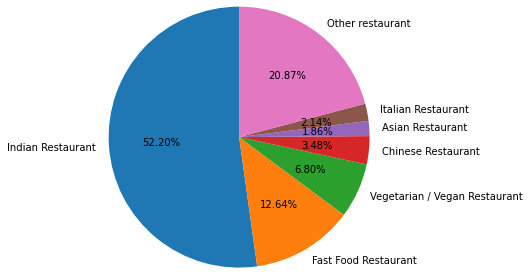

In [59]:
x = np.append(cluster0_restaurant[target_restaurant].sum().values, cluster0_restaurant['Restaurant fraction'].sum()-cluster0_restaurant[target_restaurant].sum().sum())
labels = np.append(cluster0_restaurant[target_restaurant].sum().index, 'Other restaurant')
plt.pie(x=x, labels=labels, radius=1.5, startangle=90, autopct="%.2f%%");

Based on the above data, the following insights are concluded. We will target only the neighborhood with less than 20% of restaurant - suitable for opening any type of restaurant, but not already established restaurant,

**Any type of restaurant** (preferably Indian)
  * Madhavaram
  * Madhavaram Milk Colony
  * Vallalar Nagar

**Fast Food, Chinese, Asian and Italian restaurant**
* Kazhipattur (also Vegetarian)
* Mangadu (also Indian)

#### Cluster 1

In [60]:
cluster1 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 1].drop(['Latitude', 'Longitude', 'Cluster Labels'], 1).reset_index(drop=True)
cluster1

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Annanur,Platform,Train Station,Indian Restaurant,Hyderabadi Restaurant,Donut Shop,Food,Flower Shop,Flea Market,Fish Market,Field
1,Eranavur,Beach,Train Station,Burmese Restaurant,Yoga Studio,Farm,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market
2,Ennore,Train Station,ATM,Art Gallery,Electronics Store,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market,Fish Market
3,Kattivakkam,Train Station,ATM,Burmese Restaurant,Electronics Store,Food & Drink Shop,Food,Flower Shop,Flea Market,Fish Market,Field
4,Korukkupet,Train Station,Light Rail Station,Women's Store,Vegetarian / Vegan Restaurant,Yoga Studio,Food & Drink Shop,Food,Flower Shop,Flea Market,Fish Market
5,Mannady,Train Station,Ice Cream Shop,Indian Restaurant,Food Truck,Video Store,Bakery,Fast Food Restaurant,Department Store,Spa,Field
6,Minjur,Train Station,Park,Department Store,Scenic Lookout,Yoga Studio,Electronics Store,Food,Flower Shop,Flea Market,Fish Market
7,Nemilichery,Train Station,Pharmacy,Coffee Shop,Yoga Studio,Donut Shop,Food,Flower Shop,Flea Market,Fish Market,Field
8,Peerkankaranai,Train Station,Bus Station,Cafeteria,Construction & Landscaping,Bakery,Farm,Food & Drink Shop,Food,Flower Shop,Flea Market
9,Pulianthope,Platform,Light Rail Station,Train Station,Food & Drink Shop,Food,Flower Shop,Flea Market,Fish Market,Field,Fast Food Restaurant


In [61]:
Counter(cluster1.to_numpy().flatten()).most_common(10)

[('Train Station', 14),
 ('Food', 12),
 ('Flower Shop', 10),
 ('Flea Market', 10),
 ('Fish Market', 8),
 ('Food & Drink Shop', 8),
 ('Field', 6),
 ('Yoga Studio', 6),
 ('Fast Food Restaurant', 5),
 ('Indian Restaurant', 4)]

Cluster 1 has high market density with fewer medium popular restaurant type. This cluster can be considered as one of the optimal place to open medium popular restaurant type.

In [62]:
cluster1_restaurant = chennai_restaurant_density.loc[chennai_restaurant_density['Cluster Labels'] == 1].drop(['Latitude', 'Longitude', 'Cluster Labels'], 1).reset_index(drop=True)
cluster1_restaurant.insert(1, 'Restaurant fraction', cluster1_restaurant.sum(axis=1))

cluster1_restaurant

,Neighborhood,Restaurant fraction,Chinese Restaurant,Indian Restaurant,Rajasthani Restaurant,Vegetarian / Vegan Restaurant,Restaurant,Punjabi Restaurant,Mexican Restaurant,Japanese Restaurant,Fast Food Restaurant,Italian Restaurant,Mediterranean Restaurant,Asian Restaurant,Kebab Restaurant,North Indian Restaurant,Middle Eastern Restaurant,Comfort Food Restaurant,Diner,South Indian Restaurant,Thai Restaurant,Kerala Restaurant,African Restaurant,Modern European Restaurant,Malay Restaurant,American Restaurant,New American Restaurant,Multicuisine Indian Restaurant,Seafood Restaurant,Japanese Curry Restaurant,Korean Restaurant,Burmese Restaurant,Bengali Restaurant,Molecular Gastronomy Restaurant,Afghan Restaurant,Chettinad Restaurant,Hyderabadi Restaurant,Steakhouse,Andhra Restaurant,Parsi Restaurant,Persian Restaurant,Portuguese Restaurant,Halal Restaurant
0,Annanur,0.250000,0.000000,0.250000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Eranavur,0.200000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Ennore,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Kattupakkam,0.500000,0.000000,0.250000,0.0,0.000000,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Korukkupet,0.200000,0.000000,0.000000,0.0,0.200000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Mathur,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Mogappair,0.444444,0.111111,0.222222,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Nemilichery,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Peerkankaranai,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Pulianthope,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Target Restaurant

In [63]:
cluster1_restaurant[['Neighborhood', 'Restaurant fraction'] + target_restaurant]

,Neighborhood,Restaurant fraction,Indian Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Chinese Restaurant,Asian Restaurant,Italian Restaurant
0,Annanur,0.250000,0.250000,0.000000,0.000000,0.000000,0.0,0.0
1,Eranavur,0.200000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,Ennore,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3,Kattupakkam,0.500000,0.250000,0.250000,0.000000,0.000000,0.0,0.0
4,Korukkupet,0.200000,0.000000,0.000000,0.200000,0.000000,0.0,0.0
5,Mathur,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
6,Mogappair,0.444444,0.222222,0.000000,0.000000,0.111111,0.0,0.0
7,Nemilichery,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
8,Peerkankaranai,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
9,Pulianthope,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0


In [64]:
cluster1_restaurant[target_restaurant].mean()

Indian Restaurant                0.073696
Fast Food Restaurant             0.036990
Vegetarian / Vegan Restaurant    0.024490
Chinese Restaurant               0.018141
Asian Restaurant                 0.000000
Italian Restaurant               0.000000
dtype: float64

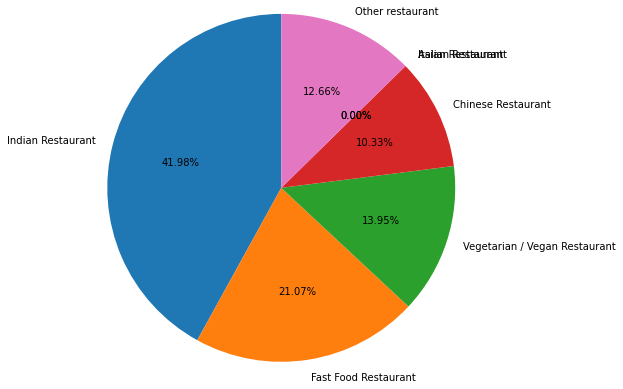

In [65]:
x = np.append(cluster1_restaurant[target_restaurant].sum().values, cluster1_restaurant['Restaurant fraction'].sum()-cluster1_restaurant[target_restaurant].sum().sum())*100
labels = np.append(cluster1_restaurant[target_restaurant].sum().index, 'Other restaurant')
plt.pie(x=x, labels=labels, radius=2, startangle=90, autopct="%.2f%%");

Based on the above data, the following insights are concluded. We will target only the neighborhood with less than 20% of restaurant, suitable for opening any type of restaurant, but not already established restaurant.

**Any type of restaurant**
* Eranavur, Ennore, Mathur, Nemilichery, Peerkankaranai, Pulianthope (preferably Indian)
* Royapuram, Washermanpet (except Fast Food)
* Korukkupet (except Vegetarian)
* Thiruninravur (except Indian)

This cluster has no Asian and Italian type restaurant. Opening these type of restaurant is done after properly analyzing the area and people.

#### Cluster 2

In [66]:
cluster2 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 2].drop(['Latitude', 'Longitude', 'Cluster Labels'], 1).reset_index(drop=True)
cluster2

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Mudichur,Pharmacy,Yoga Studio,Electronics Store,Food & Drink Shop,Food,Flower Shop,Flea Market,Fish Market,Field,Fast Food Restaurant
1,Puthagaram,Food & Drink Shop,Pharmacy,Yoga Studio,Electronics Store,Food,Flower Shop,Flea Market,Fish Market,Field,Fast Food Restaurant
2,Surapet,Food & Drink Shop,Snack Place,Pharmacy,Bus Stop,Electronics Store,Food,Flower Shop,Flea Market,Fish Market,Field


In [67]:
Counter(cluster2.to_numpy().flatten()).most_common(10)

[('Pharmacy', 3),
 ('Electronics Store', 3),
 ('Food & Drink Shop', 3),
 ('Food', 3),
 ('Flower Shop', 3),
 ('Flea Market', 3),
 ('Fish Market', 3),
 ('Field', 3),
 ('Yoga Studio', 2),
 ('Fast Food Restaurant', 2)]

Cluster 2 has negligible restaurant density. Opening a new restaurant in this cluster can be profitable.

In [68]:
cluster2_restaurant = chennai_restaurant_density.loc[chennai_restaurant_density['Cluster Labels'] == 2].drop(['Latitude', 'Longitude', 'Cluster Labels'], 1).reset_index(drop=True)
cluster2_restaurant.insert(1, 'Restaurant fraction', cluster2_restaurant.sum(axis=1))

cluster2_restaurant

,Neighborhood,Restaurant fraction,Chinese Restaurant,Indian Restaurant,Rajasthani Restaurant,Vegetarian / Vegan Restaurant,Restaurant,Punjabi Restaurant,Mexican Restaurant,Japanese Restaurant,Fast Food Restaurant,Italian Restaurant,Mediterranean Restaurant,Asian Restaurant,Kebab Restaurant,North Indian Restaurant,Middle Eastern Restaurant,Comfort Food Restaurant,Diner,South Indian Restaurant,Thai Restaurant,Kerala Restaurant,African Restaurant,Modern European Restaurant,Malay Restaurant,American Restaurant,New American Restaurant,Multicuisine Indian Restaurant,Seafood Restaurant,Japanese Curry Restaurant,Korean Restaurant,Burmese Restaurant,Bengali Restaurant,Molecular Gastronomy Restaurant,Afghan Restaurant,Chettinad Restaurant,Hyderabadi Restaurant,Steakhouse,Andhra Restaurant,Parsi Restaurant,Persian Restaurant,Portuguese Restaurant,Halal Restaurant
0,Mugalivakkam,0.4,0.04,0.08,0.0,0.04,0.04,0.0,0.0,0.0,0.0,0.08,0.0,0.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.0
1,Puthagaram,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
2,Surapet,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0


In [69]:
cluster2_restaurant[['Neighborhood', 'Restaurant fraction'] + target_restaurant]

,Neighborhood,Restaurant fraction,Indian Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Chinese Restaurant,Asian Restaurant,Italian Restaurant
0,Mugalivakkam,0.4,0.08,0.0,0.04,0.04,0.08,0.08
1,Puthagaram,0.0,0.00,0.0,0.00,0.00,0.00,0.00
2,Surapet,0.0,0.00,0.0,0.00,0.00,0.00,0.00


In [70]:
cluster2_restaurant[target_restaurant].mean()

Indian Restaurant                0.026667
Fast Food Restaurant             0.000000
Vegetarian / Vegan Restaurant    0.013333
Chinese Restaurant               0.013333
Asian Restaurant                 0.026667
Italian Restaurant               0.026667
dtype: float64

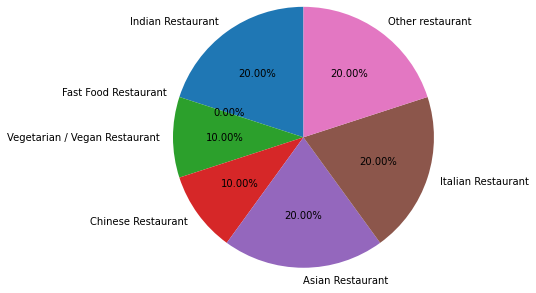

In [71]:
x = np.append(cluster2_restaurant[target_restaurant].sum().values, cluster2_restaurant['Restaurant fraction'].sum()-cluster2_restaurant[target_restaurant].sum().sum())*100
labels = np.append(cluster2_restaurant[target_restaurant].sum().index, 'Other restaurant')
plt.pie(x=x, labels=labels, radius=1.5, startangle=90, autopct="%.2f%%");

Based on the above data, the following insights are concluded. We will target only the neighborhood with less than 20% of restaurant, suitable for opening any type of restaurant, but not already established restaurant.

**Any type of restaurant** (preferably Indian)

* Puthagaram
* Surapet

This cluster has no Fast Food restaurant. Opening these type of restaurant is done after properly analyzing the area and people.

#### Cluster 3

In [72]:
cluster3 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 3].drop(['Latitude', 'Longitude', 'Cluster Labels'], 1).reset_index(drop=True)
cluster3

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adambakkam,Indian Restaurant,Pizza Place,Vegetarian / Vegan Restaurant,Café,Sandwich Place,Coffee Shop,Clothing Store,Multiplex,Fast Food Restaurant,Chinese Restaurant
1,Alapakkam,Asian Restaurant,Department Store,Clothing Store,Fast Food Restaurant,Sandwich Place,Bakery,Restaurant,Indian Restaurant,Hotel,Vegetarian / Vegan Restaurant
2,Alwarpet,Hotel,Indian Restaurant,Italian Restaurant,Restaurant,Café,Lounge,Chinese Restaurant,Bakery,Dessert Shop,Ice Cream Shop
3,Alwarthirunagar,Indian Restaurant,Fast Food Restaurant,Pizza Place,Clothing Store,Café,Sandwich Place,Burger Joint,Playground,Movie Theater,Paper / Office Supplies Store
4,Ambattur,Ice Cream Shop,Movie Theater,Gym,Department Store,River,Bus Station,Pizza Place,Asian Restaurant,Convenience Store,Train Station
...,...,...,...,...,...,...,...,...,...,...,...
79,Vadapalani,Indian Restaurant,Pizza Place,Hotel,Bakery,Fast Food Restaurant,Clothing Store,Multiplex,Coffee Shop,Movie Theater,South Indian Restaurant
80,Valasaravakkam,Fast Food Restaurant,Department Store,Indian Restaurant,Bakery,Vegetarian / Vegan Restaurant,Pizza Place,Asian Restaurant,Shopping Mall,Bank,Restaurant
81,Vallalar Nagar,ATM,Supermarket,National Park,Platform,Hotel,Donut Shop,Flower Shop,Flea Market,Fish Market,Field
82,Virugambakkam,Bakery,Pizza Place,Clothing Store,Antique Shop,Café,Chinese Restaurant,Fast Food Restaurant,Gym,Sandwich Place,Indian Restaurant


In [73]:
Counter(cluster3.to_numpy().flatten()).most_common(10)

[('Indian Restaurant', 47),
 ('Pizza Place', 38),
 ('Café', 32),
 ('Flower Shop', 31),
 ('Fast Food Restaurant', 29),
 ('Food', 29),
 ('Bakery', 28),
 ('Coffee Shop', 24),
 ('Hotel', 24),
 ('Clothing Store', 23)]

Cluster 3 is very similar to Cluster 0 with high restaurant density. Further analysis can uncover some useful information about the cluster.

In [74]:
cluster3_restaurant = chennai_restaurant_density.loc[chennai_restaurant_density['Cluster Labels'] == 3].drop(['Latitude', 'Longitude', 'Cluster Labels'], 1).reset_index(drop=True)
cluster3_restaurant.insert(1, 'Restaurant fraction', cluster3_restaurant.sum(axis=1))

cluster3_restaurant

,Neighborhood,Restaurant fraction,Chinese Restaurant,Indian Restaurant,Rajasthani Restaurant,Vegetarian / Vegan Restaurant,Restaurant,Punjabi Restaurant,Mexican Restaurant,Japanese Restaurant,Fast Food Restaurant,Italian Restaurant,Mediterranean Restaurant,Asian Restaurant,Kebab Restaurant,North Indian Restaurant,Middle Eastern Restaurant,Comfort Food Restaurant,Diner,South Indian Restaurant,Thai Restaurant,Kerala Restaurant,African Restaurant,Modern European Restaurant,Malay Restaurant,American Restaurant,New American Restaurant,Multicuisine Indian Restaurant,Seafood Restaurant,Japanese Curry Restaurant,Korean Restaurant,Burmese Restaurant,Bengali Restaurant,Molecular Gastronomy Restaurant,Afghan Restaurant,Chettinad Restaurant,Hyderabadi Restaurant,Steakhouse,Andhra Restaurant,Parsi Restaurant,Persian Restaurant,Portuguese Restaurant,Halal Restaurant
0,Adambakkam,0.383333,0.033333,0.100000,0.016667,0.066667,0.016667,0.016667,0.016667,0.016667,0.033333,0.016667,0.016667,0.016667,0.016667,0.0,0.0,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
1,Alapakkam,0.500000,0.000000,0.083333,0.000000,0.083333,0.083333,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.166667,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
2,Alwarpet,0.350000,0.040000,0.070000,0.000000,0.010000,0.050000,0.000000,0.000000,0.020000,0.000000,0.060000,0.010000,0.000000,0.000000,0.0,0.0,0.01,0.000000,0.020000,0.02,0.01,0.01,0.01,0.01,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
3,Alwarthirunagar,0.296296,0.037037,0.111111,0.000000,0.037037,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
4,Ambattur,0.153846,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,Vadapalani,0.338983,0.016949,0.152542,0.000000,0.016949,0.016949,0.000000,0.000000,0.000000,0.050847,0.016949,0.000000,0.016949,0.000000,0.0,0.0,0.00,0.000000,0.033898,0.00,0.00,0.00,0.00,0.00,0.016949,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
80,Valasaravakkam,0.440000,0.000000,0.080000,0.000000,0.080000,0.040000,0.000000,0.000000,0.000000,0.120000,0.000000,0.000000,0.080000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.0,0.0,0.0
81,Vanagaram,0.750000,0.000000,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
82,Virugambakkam,0.176471,0.058824,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
cluster3_restaurant[['Neighborhood', 'Restaurant fraction'] + target_restaurant]

,Neighborhood,Restaurant fraction,Indian Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Chinese Restaurant,Asian Restaurant,Italian Restaurant
0,Adambakkam,0.383333,0.100000,0.033333,0.066667,0.033333,0.016667,0.016667
1,Alapakkam,0.500000,0.083333,0.083333,0.083333,0.000000,0.166667,0.000000
2,Alwarpet,0.350000,0.070000,0.000000,0.010000,0.040000,0.000000,0.060000
3,Alwarthirunagar,0.296296,0.111111,0.111111,0.037037,0.037037,0.000000,0.000000
4,Ambattur,0.153846,0.076923,0.000000,0.000000,0.000000,0.076923,0.000000
...,...,...,...,...,...,...,...,...
79,Vadapalani,0.338983,0.152542,0.050847,0.016949,0.016949,0.016949,0.016949
80,Valasaravakkam,0.440000,0.080000,0.120000,0.080000,0.000000,0.080000,0.000000
81,Vanagaram,0.750000,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000
82,Virugambakkam,0.176471,0.058824,0.058824,0.000000,0.058824,0.000000,0.000000


In [76]:
cluster3_restaurant[cluster3_restaurant['Restaurant fraction'] <= .2][['Neighborhood', 'Restaurant fraction'] + target_restaurant]

,Neighborhood,Restaurant fraction,Indian Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Chinese Restaurant,Asian Restaurant,Italian Restaurant
4,Ambattur,0.153846,0.076923,0.000000,0.0,0.000000,0.076923,0.0
6,Ayanavaram,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
9,Chitlapakkam,0.100000,0.100000,0.000000,0.0,0.000000,0.000000,0.0
18,K.K. Nagar,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
20,Kodungaiyur,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
21,Korattur,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
24,Kottur,0.142857,0.142857,0.000000,0.0,0.000000,0.000000,0.0
26,Kundrathur,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
28,Madambakkam,0.200000,0.200000,0.000000,0.0,0.000000,0.000000,0.0
29,Manali New Town,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0


In [77]:
cluster3_restaurant[target_restaurant].mean()

Indian Restaurant                0.097639
Fast Food Restaurant             0.039858
Vegetarian / Vegan Restaurant    0.024506
Chinese Restaurant               0.015784
Asian Restaurant                 0.015971
Italian Restaurant               0.007607
dtype: float64

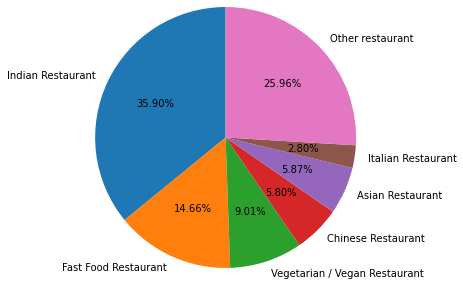

In [78]:
x = np.append(cluster3_restaurant[target_restaurant].sum().values, cluster3_restaurant['Restaurant fraction'].sum()-cluster3_restaurant[target_restaurant].sum().sum())
labels = np.append(cluster3_restaurant[target_restaurant].sum().index, 'Other restaurant')
plt.pie(x=x, labels=labels, radius=1.5, startangle=90, autopct="%.2f%%");

Based on the above data, the following insights are concluded. We will target only the neighborhood with less than 20% of restaurant, suitable for opening any type of restaurant, but not already established restaurant.

**Any type of restaurant**

* Ayanavaram, K.K. Nagar, Kodungaiyur, Korattur, Kundrathur, Manali New Town, Minjur, Moolakadai, Mudichur, Pammal, Pattabiram, Pattaravakkam, Perumbakkam, Perungalathur, Poonamallee, Puzhal, Sholavaram, Vandalur (preferably Indian)

* Chitlapakkam, Kottur, Madambakkam, Mannady, Nanganallur, Selaiyur, Sholinganallur, Thiruneermalai (except Indian)

* Perambur (except Chinese)

* Peravallur (except Asian)

## Results <a name="results"></a>

The summary of our analysis are,

* We categorized the neighbors using **K-means clustering** algorithm based on the density of venues.

* We chose **4 clusters** which is optimal according **Silhouette Coefficient** of finding optimal cluster.

* **Cluster 0** - Full of restaurant and other food shop - only **8%** of the areas has opportunity to open new restaurant.

* **Cluster 1** - High market density with fewer medium popular restaurant type - **74%** of the area has promising opportunity for opening a new restaurant - This cluster has no Asian and Italian restaurant.

* **Cluster 2** - Negligible restaurant density - Out of 3 areas, **2 areas** do not have a single restaurant.

* **Cluster 3** - High restaurant density, very similar to Cluster 0 - **36%** of the area has opportunity to open new restaurant.

## Conclusion and Discussion <a name="conclusion"></a>

The purpose of this project was to identify the optimal location for opening some of the popular restaurant type namely, Indian, Fast Food, Vegetarian, Chinese, Asian and Italian restaurant. Factors like venue density distribution are used to achieve our task.

First, we scraped the neighborhood information of Chennai city from the Wikipedia website and used python’s geocoder library to get the coordinate information of each of the neighborhoods. Then, we utilized Foursquare data to fetch and identify all the venues within each neighborhood. We then clustered the neighborhood based on the venue density. Each cluster provided useful information and insights about the venues and restaurants that are briefly discussed in analysis and result section, that are helpful for the stakeholders.

We can also apply the same approach for the larger dataset. This approach can also be applied to identify promising location for shopping malls, movie theaters and other related business. In this project, we considered only one factor, that is, venue density distribution. There are some other most useful factors like population and income of residents, real estate availability, surrounding localities, financial report etc., can be really helpful to further narrow down the choice of selecting the optimal location by the stakeholders based on specific characteristics of neighborhoods and locations.

Final decision on selecting the optimal location for the restaurant will be made by stakeholders based on specific characteristics of neighborhoods and locations in every area, taking additional factors into consideration that are discussed above.